# DAT210x - Programming with Python for DS

## Module4- Lab2

In Lab Assignment 1, you applied PCA to a dataset generated by 3D-scanning an actual sculpture. Real life 3D objects are a good segue to PCA, since it's fun to see its effects on a dataset we can visualize and touch. Another benefit is that all three spatial dimensions, x, y, and z, each measure the same unit-type relative (length), so no extra consideration need be made to account for PCA's weakness of requiring feature scaling.

But now the fun is over. Gaining some practical experience with real-world datasets, which rarely allot you the luxury of having features all of the same scale, will help you see how critical feature scaling is to PCA. In this lab, you're going to experiment with a subset of UCI's Chronic Kidney Disease data set, a collection of samples taken from patients in India over a two month period, some of whom were in the early stages of the disease. There is some starter code for you available in /Module4/Module4 - Lab2.ipynb.

Start the lab by looking through the attribute information on the dataset website. Whenever you are given a dataset, the first thing you should do is find out as much about it as possible, both by reading up on any metadata, as well as by prodding through the actual data. Particularly, pay attention to what the docs say about these three variables: bgr, rc, and wc.

After that, go ahead and load up the kidney_disease.csv dataset from the /Module4/Datasets/ directory. Follow the rest of the steps and reading in the notebook to complete the assignment. Pay special attention to the dataframe's dtypes as assigned by Pandas. You may have to coerce a column into a different data type, if necessary. The last thing you'll do is reduce your dataset down to two principal components by running it through PCA, and then visualizing the resulting output.

In [32]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA

In [6]:
# Look pretty...

# matplotlib.style.use('ggplot')
plt.style.use('ggplot')

### Some Boilerplate Code

For your convenience, we've included some boilerplate code here which will help you out. You aren't expected to know how to write this code on your own at this point, but it'll assist with your visualizations. We've added some notes to the code in case you're interested in knowing what it's doing:

### A Note on SKLearn's `.transform()` calls:

Any time you perform a transformation on your data, you lose the column header names because the output of SciKit-Learn's `.transform()` method is an NDArray and not a daraframe.

This actually makes a lot of sense because there are essentially two types of transformations:
- Those that adjust the scale of your features, and
- Those that change alter the number of features, perhaps even changing their values entirely.

An example of adjusting the scale of a feature would be changing centimeters to inches. Changing the feature entirely would be like using PCA to reduce 300 columns to 30. In either case, the original column's units have either been altered or no longer exist at all, so it's up to you to assign names to your columns after any transformation, if you'd like to store the resulting NDArray back into a dataframe.

In [7]:
def scaleFeaturesDF(df):
    # Feature scaling is a type of transformation that only changes the
    # scale, but not number of features. Because of this, we can still
    # use the original dataset's column names... so long as we keep in
    # mind that the _units_ have been altered:

    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    
    print("New Variances:\n", scaled.var())
    print("New Describe:\n", scaled.describe())
    return scaled

SKLearn contains many methods for transforming your features by scaling them, a type of pre-processing):
    - `RobustScaler`
    - `Normalizer`
    - `MinMaxScaler`
    - `MaxAbsScaler`
    - `StandardScaler`
    - ...

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

However in order to be effective at PCA, there are a few requirements that must be met, and which will drive the selection of your scaler. PCA requires your data is standardized -- in other words, it's _mean_ should equal 0, and it should have unit variance.

SKLearn's regular `Normalizer()` doesn't zero out the mean of your data, it only clamps it, so it could be inappropriate to use depending on your data. `MinMaxScaler` and `MaxAbsScaler` both fail to set a unit variance, so you won't be using them here either. `RobustScaler` can work, again depending on your data (watch for outliers!). So for this assignment, you're going to use the `StandardScaler`. Get familiar with it by visiting these two websites:

- http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
- http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

Lastly, some code to help with visualizations:

In [8]:
def drawVectors(transformed_features, components_, columns, plt, scaled):
    if not scaled:
        return plt.axes() # No cheating ;-)

    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ## visualize projections

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)

    ax = plt.axes()

    for i in range(num_columns):
        # Use an arrow to project each original feature as a
        # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75)

    return ax

### And Now, The Assignment

In [89]:
# Do * NOT * alter this line, until instructed!
# scaleFeatures = False
scaleFeatures = True

Load up the dataset specified on the lab instructions page and remove any and all _rows_ that have a NaN in them. You should be a pro at this by now ;-)

**QUESTION**: Should the `id` column be included in your dataset as a feature?

In [77]:
df = pd.read_csv('Datasets/kidney_disease.csv', index_col=0)
df.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
id,,,,,,,,,,,,,,,,,,,,,
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd


Let's build some color-coded labels; the actual label feature will be removed prior to executing PCA, since it's unsupervised. You're only labeling by color so you can see the effects of PCA:

In [78]:
labels = ['red' if i=='ckd' else 'green' for i in df.classification]

In [79]:
pd.Series(labels).value_counts()

red      248
green    152
dtype: int64

Use an indexer to select only the following columns: `['bgr','wc','rc']`

In [80]:
df = df.loc[:, ['bgr','wc','rc']]

Either take a look at the dataset's webpage in the attribute info section of UCI's [Chronic Kidney Disease]() page,: https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease or alternatively, you can actually look at the first few rows of your dataframe using `.head()`. What kind of data type should these three columns be? Compare what you see with the results when you print out your dataframe's `dtypes`.

If Pandas did not properly detect and convert your columns to the data types you expected, use an appropriate command to coerce these features to the right type.

In [81]:
df.dtypes

bgr    float64
wc      object
rc      object
dtype: object

In [82]:
df['wc'] = pd.to_numeric(df['wc'], errors='coerce')
df['rc'] = pd.to_numeric(df['rc'], errors='coerce')
df.dtypes
print(df.shape)

(400, 3)


In [83]:
df = df.fillna(df.mean())
print(df.shape)

(400, 3)


PCA Operates based on variance. The variable with the greatest variance will dominate. Examine your data using a command that will check the variance of every feature in your dataset, and then print out the results. Also print out the results of running `.describe` on your dataset.

_Hint:_ If you do not see all three variables: `'bgr'`, `'wc'`, and `'rc'`, then it's likely you probably did not complete the previous step properly.

In [84]:
print(df.var())
df.describe()

bgr    5.592442e+03
wc     6.366639e+06
rc     7.061281e-01
dtype: float64


,bgr,wc,rc
count,400.000000,400.000000,400.000000
mean,148.036517,8406.122449,4.707435
std,74.782634,2523.219976,0.840314
min,22.000000,2200.000000,2.100000
25%,101.000000,6975.000000,4.500000
50%,126.000000,8406.122449,4.707435
75%,150.000000,9400.000000,5.100000
max,490.000000,26400.000000,8.000000


Below, we assume your dataframe's variable is named `df`. If it isn't, make the appropriate changes. But do not alter the code in `scaleFeaturesDF()` just yet!

In [90]:
print(scaleFeatures)
# .. your (possible) code adjustment here ..
if scaleFeatures: 
    df = scaleFeaturesDF(df)

True
New Variances:
 bgr    1.002506
wc     1.002506
rc     1.002506
dtype: float64
New Describe:
                 bgr            wc            rc
count  4.000000e+02  4.000000e+02  4.000000e+02
mean  -2.146200e-16  1.174061e-16  8.659740e-17
std    1.001252e+00  1.001252e+00  1.001252e+00
min   -1.687482e+00 -2.462684e+00 -3.106814e+00
25%   -6.297642e-01 -5.678913e-01 -2.471631e-01
50%   -2.950433e-01  0.000000e+00  1.058283e-15
75%    2.628875e-02  3.943858e-01  4.677496e-01
max    4.578493e+00  7.140246e+00  3.923161e+00


Run PCA on your dataset, reducing it to 2 principal components. Make sure your PCA model is saved in a variable called `'pca'`, and that the results of your transformation are saved in another variable `'T'`:

In [91]:
pca = PCA(n_components=2)
T = pca.fit_transform(df.values)

Now, plot the transformed data as a scatter plot. Recall that transforming the data will result in a NumPy NDArray. You can either use MatPlotLib to graph it directly, or you can convert it back to DataFrame and have Pandas do it for you.

Since we've already demonstrated how to plot directly with MatPlotLib in `Module4/assignment1.ipynb`, this time we'll show you how to convert your transformed data back into to a Pandas Dataframe and have Pandas plot it from there.

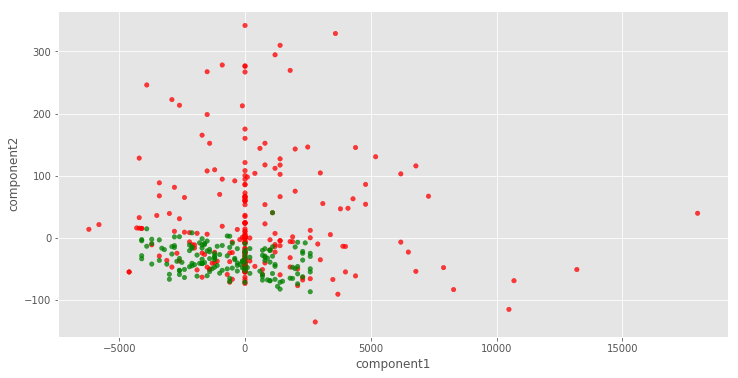

In [88]:
# Since we transformed via PCA, we no longer have column names; but we know we
# are in `principal-component` space, so we'll just define the coordinates accordingly:
plt.figure(figsize=(12,6))
ax = drawVectors(T, pca.components_, df.columns.values, plt, scaleFeatures)
T  = pd.DataFrame(T)

T.columns = ['component1', 'component2']
T.plot.scatter(x='component1', y='component2', marker='o', c=labels, alpha=0.75, ax=ax)

plt.show()

Features by importance:
 [(5.108051591528267, 'wc'), (3.8515741833649186, 'bgr'), (3.3729169039840494, 'rc')]


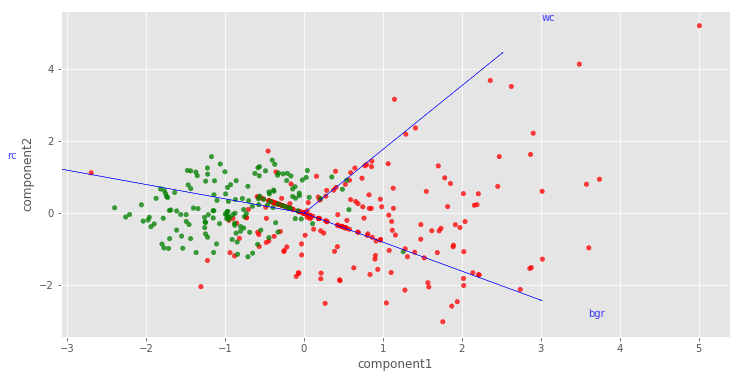

In [92]:
# Since we transformed via PCA, we no longer have column names; but we know we
# are in `principal-component` space, so we'll just define the coordinates accordingly:
plt.figure(figsize=(12,6))
ax = drawVectors(T, pca.components_, df.columns.values, plt, scaleFeatures)
T  = pd.DataFrame(T)

T.columns = ['component1', 'component2']
T.plot.scatter(x='component1', y='component2', marker='o', c=labels, alpha=0.75, ax=ax)

plt.show()